# Exercise 2b)

In this section, we do a regression analysis without any regularization terms. We train FFNN's with one and two hidden layers, with 50 neurons in each layer. They are trained with 3000 iteartions or epochs, using both stochastic gradient descent (SGD) and plain gradient descent (GD). We plot the MSE on the testing data as a function of the learning rate, as well as the testing MSE as a function of the number of iterations/epochs. 

In [ ]:
LOAD_FROM_FILE = True   # load data from file, so the bottlenecks of the program run in just a few seconds

In [ ]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates, skip_if
import pickle

plt.style.use('./utils/_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)

In [ ]:
# OLS model
ols_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=False)
)

In [ ]:
# Neural network model
network_input_size = x.shape[1]
network_output_size = 1

layer_output_sizes = [50, 50, network_output_size]
activation_funcs = [Sigmoid(), Sigmoid(), Identity()]

nn_model = NeuralNetwork(
    network_input_size,
    layer_output_sizes,
    activation_funcs,
    MSE(),
)
nn_scaler = StandardScaler() # Scaler for neural network input data

First, in order to see how the MSE develops for our neural network, we do a cross validation analysis (with five folds), and print the resulting mean MSE over the folds. We compare with the mean MSE of ordinary OLS regression. Finally, we plot the resulting mean MSE as a function of the number of iterations for the last fold, in order to clearly see the development. This part was not included in the final report. 

In [ ]:
# k-fold cross validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=44)

nn_mse = np.zeros(n_splits)
ols_mse = np.zeros(n_splits)


# loop through the five folds
for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale data
    x_train_scaled = nn_scaler.fit_transform(x_train)
    x_test_scaled = nn_scaler.transform(x_test)
    y_mean = y_train.mean()

    # Train and evaluate Neural Network
    nn_model.reset_layers(random_state=123) # Reset neural network layers
    mse_data = nn_model.train(
        StochasticGradientDescent(
            step_method = AdamStep(learning_rate=0.01),
            inputs = x_train_scaled,
            targets = y_train - y_mean,
            test_inputs = x_test_scaled,
            test_targets = y_test - y_mean
        ),
        num_iterations = 3000,
        track_mse = True
    )
    y_pred_nn = nn_model.predict(x_test_scaled) + y_mean
    nn_mse[fold_idx] = MSE()(y_pred_nn, y_test)   # calculate mse of neural network

    # Train and evaluate OLS model
    ols_model.fit(x_train, y_train - y_mean) # This model already includes a scaler
    y_pred_ols = ols_model.predict(x_test) + y_mean
    ols_mse[fold_idx] = MSE()(y_pred_ols, y_test)


In [ ]:
# Print the mean of the testing MSE for neural networks and OLS regression. 

print(f"{n_splits}-fold {'NN MSE:':10} {nn_mse.mean():.3e}")
print(f"{n_splits}-fold {'OLS MSE:':10} {ols_mse.mean():.3e}")

5-fold NN MSE:    2.751e-03
5-fold OLS MSE:   3.209e-03


## Plot mse over iterations for the last fold

Here, we make a simple plot, to get a sense of how the MSE develops as a function of the number of iterations. 

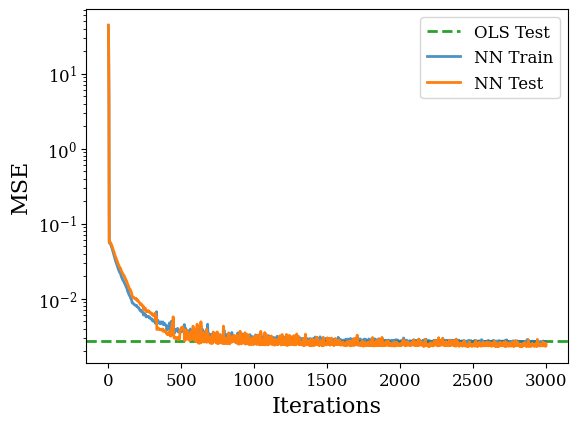

In [ ]:
plt.axhline(ols_mse[-1], color="C2", linestyle="--")
plot_mse_data(mse_data[::2]) # Plot every second point to reduce clutter from fluctuations
plt.legend(["OLS Test", "NN Train", "NN Test"])
plt.savefig("../figs/mse_nn_vs_ols.pdf")
plt.show()

## Visualize the function approximation with NN and OLS for the last fold

This is figure 3 in the report. Here, we plot the predictions of the neural network trained on the last fold, and compare with the original Runge function and the predictions of the OLS model. 

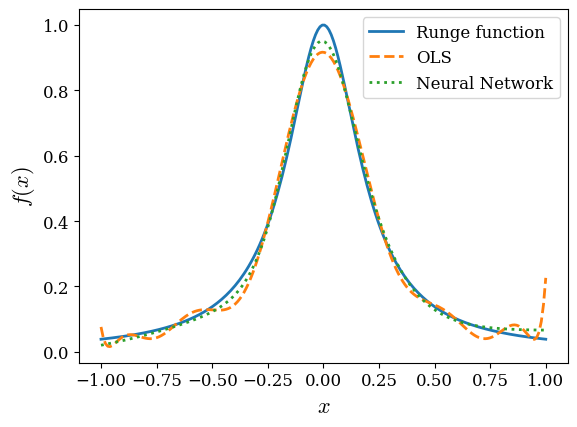

In [ ]:
x_test = np.linspace(-1,1, 200).reshape(-1, 1)

y_pred_nn = nn_model.predict(nn_scaler.transform(x_test)) + y_mean
y_pred_ols = ols_model.predict(x_test) + y_mean


plt.plot(x_test, runge(x_test), label="Runge function")
plt.plot(x_test, y_pred_ols, linestyle="dashed", label="OLS")
plt.plot(x_test, y_pred_nn, linestyle="dotted", label="Neural Network")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.savefig("../figs/runge_approximation_nn_vs_ols.pdf")
plt.show()

## MSE vs. Learning rates for different models

Here, we plot the MSE as a function of the learning rate for different gradient descent methods and neural networks. This is figure 1 in the report. 

In [ ]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [ ]:
# Define models, training methods (SGD or GD) and step method (RMSprop or Adam)
model_50 = NeuralNetwork(
    network_input_size = 1,
    layer_output_sizes = [50, 1],
    activation_funcs = [Sigmoid(), Identity()],
    cost_fun = MSE()
)
model_50_50 = NeuralNetwork(
    network_input_size = 1,
    layer_output_sizes = [50, 50, 1],
    activation_funcs = [Sigmoid(), Sigmoid(), Identity()],
    cost_fun = MSE()
)

models = [
    ("50 hidden", model_50),
    ("50+50 hidden", model_50_50)
]

# Define training methods
training_methods: list[tuple[str, type[TrainingMethod], tuple[int, int]]] = [
    ("SGD", StochasticGradientDescent, (-4, 0)),
    ("GD", GradientDescent, (-6, -2)),
]

# Step methods
step_methods: list[tuple[str, StepMethod]] = [
    ("RMSprop", RMSpropStep(0, 0.9)), 
    ("ADAM", AdamStep(0, 0.9, 0.999))
]

n_learning_rates = 9
num_iterations = 3000
all_mse_data = np.zeros((len(models), len(training_methods), len(step_methods),n_learning_rates))

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze mse vs. learning rates for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

            np.random.seed(124)
            mse_data = analyze_model_learning_rates(
                model,
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                learning_rates, 
                num_iterations,
            )
            print(".")
            all_mse_data[i][j][k] = mse_data


In [ ]:
filepath = "../data/mse_vs_lr_final.npy"

# Save data to file
#np.save(filepath, all_mse_data)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_data = np.load(filepath)

In [ ]:
# OLS for comparison
ols_model.fit(x_train, y_train - y_mean)
y_pred = ols_model.predict(x_test) + y_mean
ols_mse = MSE()(y_pred, y_test)

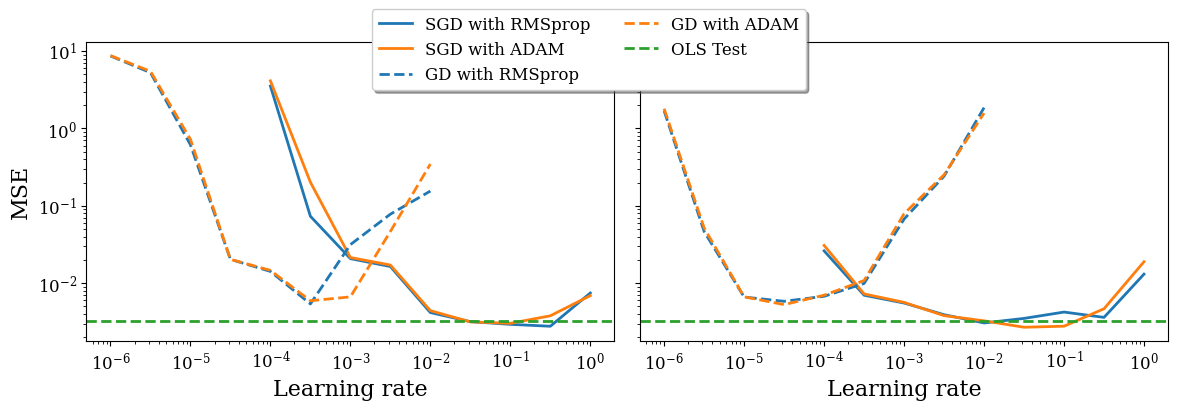

In [ ]:
# Plot MSE vs. learning rates for each model

fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_data[i][j][k]
            axes[i].plot(learning_rates, mse_data, 
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Learning rate")
    axes[i].axhline(ols_mse, label="OLS Test", color="C2", linestyle="--")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=2, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_lr.pdf")
plt.show()

## MSE vs. iterations, for each model using best learning rate found

We use the best learning rate (ie. the one associated with the minimum of the MSE) to find the MSE as a function of the number of iterations/epochs. 

In [ ]:
best_learning_rates_idx = np.argmin(all_mse_data, axis=3)  # optimal learning rate, ie. value of learning rate where a minimum of the MSE is obtained. 

In [ ]:
# Print optimal learning rates and MSE's for SGD and GD, to be used in table 1. 

learning_rates_SGD = list(np.logspace(-4, 0, n_learning_rates))
learning_rates_GD = list(np.logspace(-6, -2, n_learning_rates))

mse_SGD = all_mse_data[:,0,:,:]
mse_GD = all_mse_data[:,1,:,:]

print("Optimal learning rates for SGD: ",np.take(learning_rates_SGD,best_learning_rates_idx[:,0,:]))
print("Optimal learning rates for GD: ",np.take(learning_rates_GD,best_learning_rates_idx[:,1,:]))
print("Optimal MSE for SGD: ",mse_SGD[np.arange(mse_SGD.shape[0])[:,None],np.arange(mse_SGD.shape[1])[None,:],best_learning_rates_idx[:,0,:]])   # np.zeros((len(models), len(training_methods), len(step_methods)
print("Optimal MSE for GD: ",mse_GD[np.arange(mse_GD.shape[0])[:,None],np.arange(mse_GD.shape[1])[None,:],best_learning_rates_idx[:,1,:]]) 

all_mse_track_data = np.zeros((len(models), len(training_methods), len(step_methods), num_iterations, 2))

# save best learning rates (so it can be used in test_pytorch.ipynb)

filepath_1 = "../data/best_learning_rate_SGD_final.npy"
filepath_2 = "../data/best_learning_rate_GD_final.npy"

# Save data to file
#np.save(filepath_1,np.take(learning_rates_SGD,best_learning_rates_idx[:,0,:]))
#np.save(filepath_2,np.take(learning_rates_GD,best_learning_rates_idx[:,1,:]))

Optimal learning rates for SGD:  [[0.31622777 0.1       ]
 [0.01       0.03162278]]
Optimal learning rates for GD:  [[3.16227766e-04 3.16227766e-04]
 [3.16227766e-05 3.16227766e-05]]
Optimal MSE for SGD:  [[0.00276558 0.00301575]
 [0.003051   0.00268554]]
Optimal MSE for GD:  [[0.00537387 0.00590676]
 [0.00581439 0.00526918]]


Here, we plot the testing MSE as a function of the number of iterations/epochs for the different models and gradient descent methods. This is figure 2 in the report.  

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze mse vs. iterations/epochs for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))   # interval of learning rate values

            np.random.seed(124)
            model.reset_layers(random_state=124)
            step_method.learning_rate = learning_rates[best_learning_rates_idx[i][j][k]] # Set to best learning rate found
            mse_data = model.train(    # train NN model
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                num_iterations = num_iterations,
                n_batches=5,
                track_mse = True
            )
            all_mse_track_data[i][j][k] = mse_data[:,[0,2]] # iteration, test_mse
            print(".")

In [ ]:
filepath = "../data/mse_vs_iterations_final.npy"

# Save data to file
#np.save(filepath, all_mse_track_data)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_track_data = np.load(filepath)

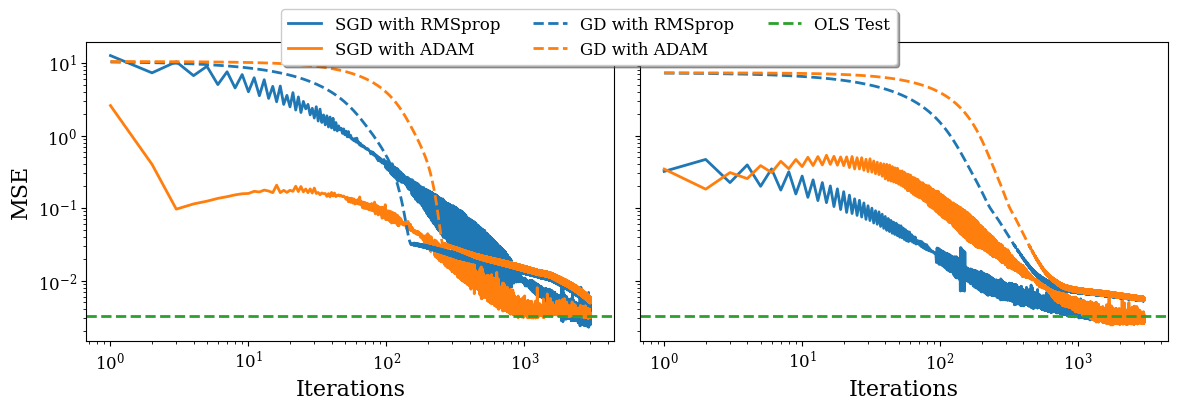

In [ ]:
# Plot MSE vs. iterations
fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rate = max_log_lr
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_track_data[i][j][k]
            axes[i].plot(mse_data[:,0], mse_data[:,1], # Every other point to reduce clutter
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Iterations")
    axes[i].axhline(ols_mse, label="OLS Test", color="C2", linestyle="--")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=3, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_iterations_best_lr.pdf")
plt.show()

In [ ]:
# Value of MSE for OLS regression 

print("MSE for OLS regression: ",ols_mse)

MSE for OLS regression:  0.003252243849281176


Next, we show a plot of the MSE as a function of the number of iterations for the maximum value of the learning rate. The point is to show that the MSE fluctuates wildly in this case, thus demonstrating an instance of the exploding gradient problem. This is the plot we referred to as being in the supplementary material in the subsection "Regression analysis without regularization" under the "Results & Discussion" section. 

Interestingly, we find that not only is the gradient large, but for plain GD, the MSE ends up oscillating back and forth around a central value that is much larger than the MSE of the optimal OLS model. Thus, it appears that the MSE gets stuck, as the gradient is so large that the model keeps overshooting the next minimum in the MSE. 

In [ ]:
all_mse_track_data_2 = np.zeros((len(models), len(training_methods), len(step_methods), num_iterations, 2))

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze mse vs. iterations/epochs for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))  # interval of learning rates

            np.random.seed(124)
            model.reset_layers(random_state=124)
            step_method.learning_rate = 10**max_log_lr   # Set to biggest learning rate
            mse_data = model.train(    # train FFNN model
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                num_iterations = num_iterations,
                n_batches=5,
                track_mse = True
            )
            all_mse_track_data_2[i][j][k] = mse_data[:,[0,2]]    # iteration, test mse of model
            print(".")

In [ ]:
filepath = "../data/mse_vs_iterations_overfitting_final.npy"

# Save data to file
#np.save(filepath, all_mse_track_data_2)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_track_data_2 = np.load(filepath)

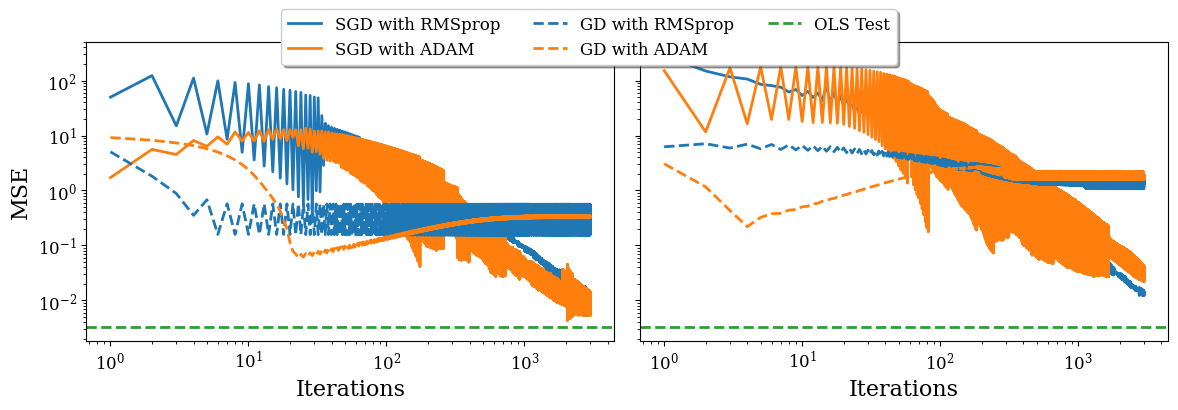

In [ ]:
# Plot MSE vs. iterations/epochs for each gradient descent algorithm/method. 
fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rate = max_log_lr
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_track_data_2[i][j][k]
            axes[i].plot(mse_data[:,0], mse_data[:,1], # Every other point to reduce clutter
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Iterations")
    axes[i].axhline(ols_mse, label="OLS Test", color="C2", linestyle="--")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=3, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_iterations_biggest_lr.pdf")
plt.show()